# Исследование оттока клиентов

Заказчик : Телеком


Цель: Cоздание модели прогнозирования оттока клиентов

Примерный план работы:

    1) Знакомство с данными
        - анализ датафреймов 
        - сбор всех датафреймов в один
        - очистка данных + приведение данных в нужный тип(вид)
        - возможно генерация новых фичей
        
    2) Построение нескольких моделей машинного обучения
        - разбиение на тренировочную и тестовую выборки
        - построение моделей
        - расчет accuracy
        
    3) Анализ результатов
        - ROC-AUC
        - признаки
        
    4) Построение наилучшей модели на уточненных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

import phik
from phik.report import plot_correlation_matrix

In [2]:
df_contract = pd.read_csv('C://Python//ЯП//final_provider//contract.csv')
df_internet = pd.read_csv('C://Python//ЯП//final_provider//internet.csv')
df_personal = pd.read_csv('C://Python//ЯП//final_provider//personal.csv')
df_phone = pd.read_csv('C://Python//ЯП//final_provider//phone.csv')

## Знакомство с данными

### Анализ датафрейма contract

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - BeginDate - дата начала
   - EndDate - дата окончания
   - Type - тип
   - PaperlessBilling - Безбумажный биллинг 
   - PaymentMethod - способ оплаты
   - MonthlyCharges - ежемесячные платежи
   - TotalCharges - всего начислений

In [3]:
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [4]:
df_contract['target_value']=df_contract['EndDate'].apply(lambda x: 1 if x == 'No' else 0)

In [5]:
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,0


In [6]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   target_value      7043 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


колонку TotalCharges необходимо привести к численному формату, после этого, с помощью .describe() посмотрим основные метрики
колонку BeginDate нужно привести к формату даты

Согласно условию задачи данные актуальны на 1 февраля 2020, поэтому можем заменить No на эту дату

In [7]:
df_contract['EndDate']=df_contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

In [8]:
df_contract['EndDate'].unique()

array(['2020-02-01', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [9]:
df_contract['BeginDate'].isnull().sum()

0

In [10]:
df_contract['BeginDate']=pd.to_datetime(df_contract['BeginDate'].astype(str), format='%Y/%m/%d')
df_contract['EndDate']=pd.to_datetime(df_contract['EndDate'].astype(str), format='%Y/%m/%d')


In [11]:
df_contract['time_delta'] = df_contract['EndDate'] - df_contract['BeginDate']
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,1,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,61 days


In [12]:
df_contract['time_delta'] = df_contract['time_delta'].astype('str')

In [13]:
df_contract['time_delta'] = df_contract['time_delta'].str.replace(' days','').astype(int)

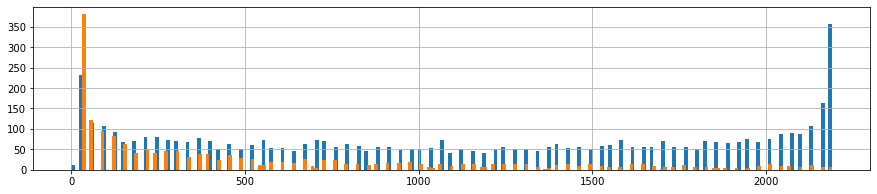

In [14]:
df_contract[df_contract['target_value'] == 1]['time_delta'].hist(bins = 200, figsize = (15, 3));
df_contract[df_contract['target_value'] == 0]['time_delta'].hist(bins = 200, figsize = (15, 3));

Обатим внимание, что отсутствие у таргетной группы ==0 высоких значений time_delta после 2000 можно считать за признак.

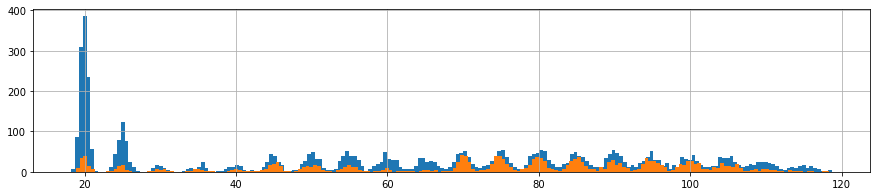

In [15]:
df_contract[df_contract['target_value'] == 1]['MonthlyCharges'].hist(bins = 200, figsize = (15, 3));
df_contract[df_contract['target_value'] == 0]['MonthlyCharges'].hist(bins = 200, figsize = (15, 3));

In [16]:
df_contract['customerID'].duplicated().sum()

0

In [17]:
df_contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target_value        0
time_delta          0
dtype: int64

#### Исследование колонки TotalCharges и перевод к численному формату

Попробуем посмотреть какие данные есть в колонке

In [18]:
df_contract['TotalCharges'].value_counts().head(20)

         11
20.2     11
19.75     9
19.9      8
20.05     8
19.65     8
19.55     7
45.3      7
20.15     6
20.25     6
19.45     6
20.45     5
20.3      5
44        4
19.5      4
69.6      4
19.3      4
69.9      4
20.35     4
19.4      4
Name: TotalCharges, dtype: int64

наблюдаем какие то пробелы вместо цифр. Следует задать вопрос "почему так?", но сейчас заменим нулями. (хотя в дальнейшем можно будет их удалить,т.к. потери не большие)

проверим заодно нет ли уже у нас в таблице нулей

In [19]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == 0)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta


In [20]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,1,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,1,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,1,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,1,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,1,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,1,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,1,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,1,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,1,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,1,0


нулей нет, можем осуществлять замену

Посмотрим на кол-во строк с пропусками

In [21]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')].count()

customerID          11
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
target_value        11
time_delta          11
dtype: int64

их 11

In [22]:
df_contract=df_contract.drop(df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')].index)

удалим

In [23]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')].count()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target_value        0
time_delta          0
dtype: int64

Теперь изменим тип данных этой колонки

In [24]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)

построим гистограмму

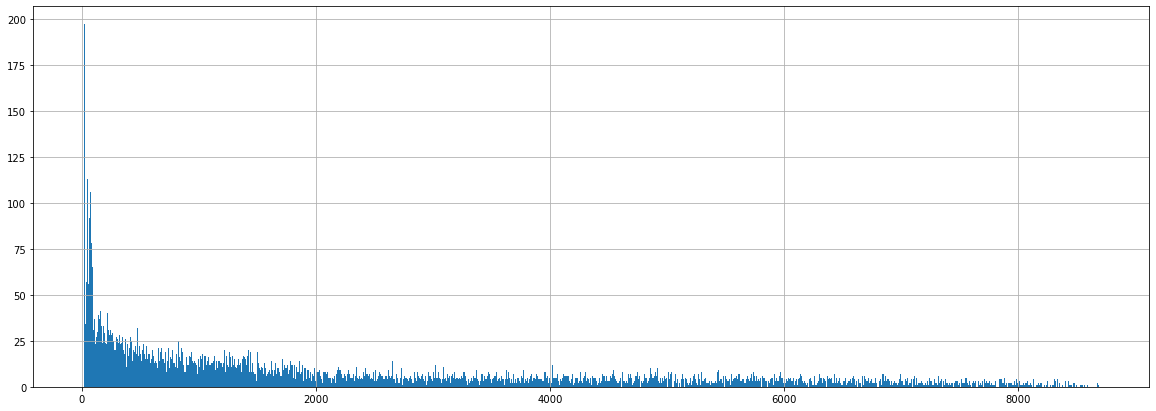

In [25]:
df_contract['TotalCharges'].hist(figsize=(20,7), bins=1000);

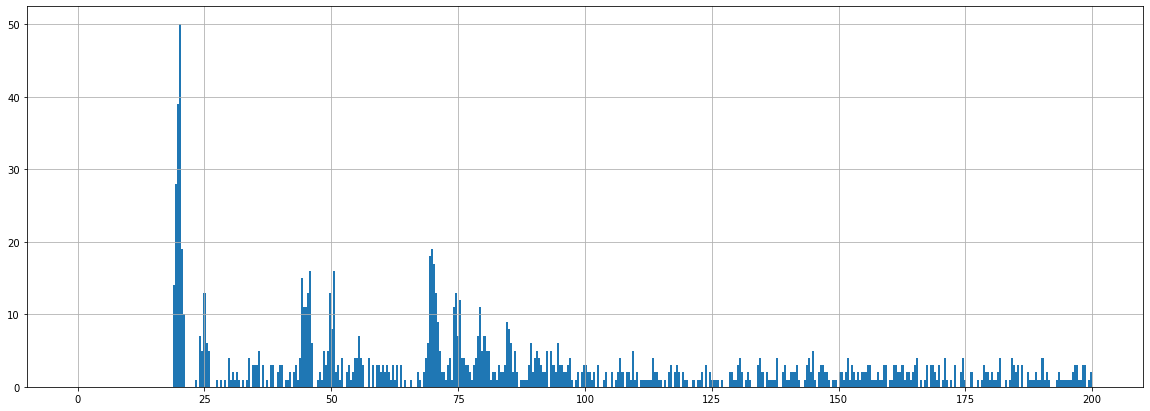

In [26]:
df_contract['TotalCharges'].hist(figsize=(20,7), bins=500, range=(0,200));

При более деттальном рассмотрении увидели что максимумы приходятся окресности чисел 20, 45, 50, 70, 75 . Или если "округлить", то от 20 до 85

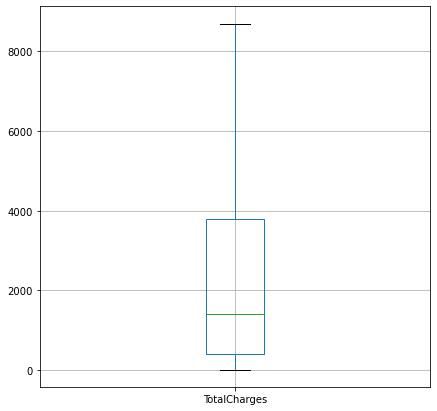

In [27]:
df_contract[['TotalCharges']].boxplot(figsize = (7,7));

Как и собирались, посмотрим основные метрики двух наших числовых столбцов

In [28]:
df_contract.describe()

,MonthlyCharges,TotalCharges,target_value,time_delta
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.734215,987.538538
std,30.085974,2266.771362,0.441782,747.153663
min,18.250000,18.800000,0.000000,30.000000
25%,35.587500,401.450000,0.000000,275.000000
50%,70.350000,1397.475000,1.000000,883.000000
75%,89.862500,3794.737500,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


медиана сильно отличается от средней, что может говорить о выбросах

Попробуем сгенерировать еще фичей

In [29]:
df_contract['TotalCharges_id']=df_contract['TotalCharges'].apply(lambda x: 0 if x > 2500 else 1)

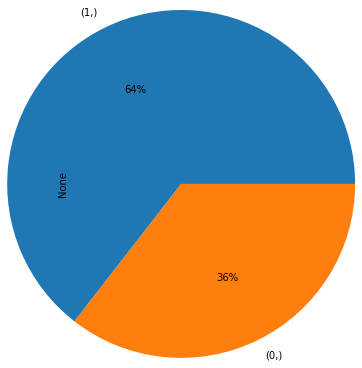

In [30]:
df_contract[['TotalCharges_id']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

#### Исследование колонки MonthlyCharges

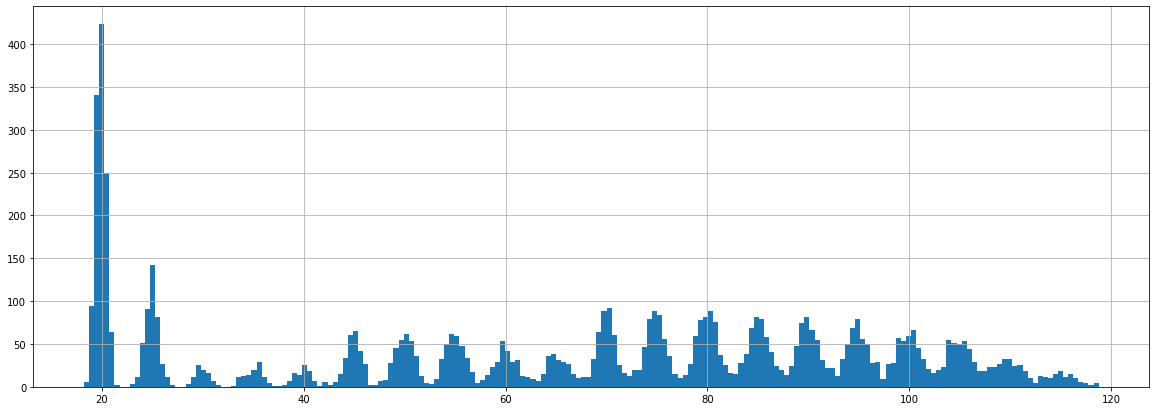

In [31]:
df_contract['MonthlyCharges'].hist(figsize=(20,7), bins=200);

пиковые значения в районе 20

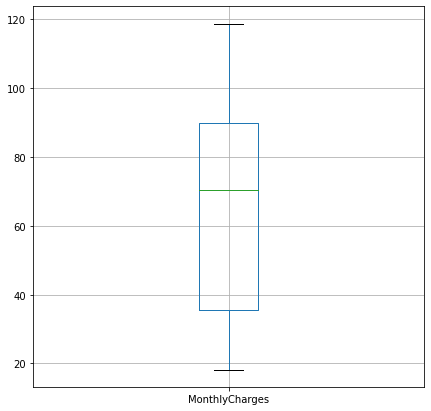

In [32]:
df_contract[['MonthlyCharges']].boxplot(figsize = (7,7));

#### Остальные колонки

 Исследование колонки EndDate

target_value
1               5163
0               1869
dtype: int64


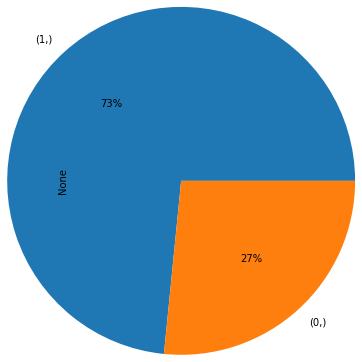

In [33]:
print(df_contract[['target_value']].value_counts())
df_contract[['target_value']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

У нас явный дисбаланс классов

 Исследование колонки EndDate

EndDate   
2020-02-01    5163
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
dtype: int64


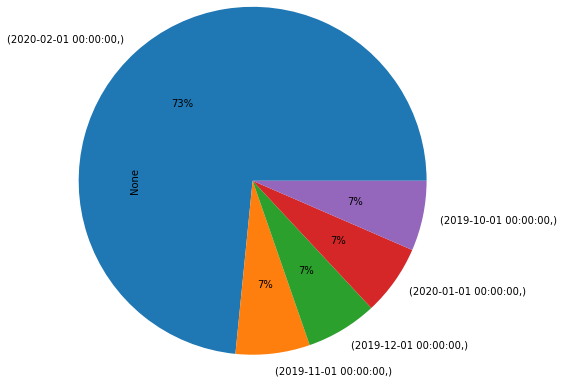

In [34]:
print(df_contract[['EndDate']].value_counts())
df_contract[['EndDate']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

Большая часть клиентов "No", как я понял, всё еще наши клиенты (не ушли от нас)

И мы видим 4 практически одинаковые волны "уходов" по 7% каждая

Исследование колонки Type

Type          
Month-to-month    3875
Two year          1685
One year          1472
dtype: int64


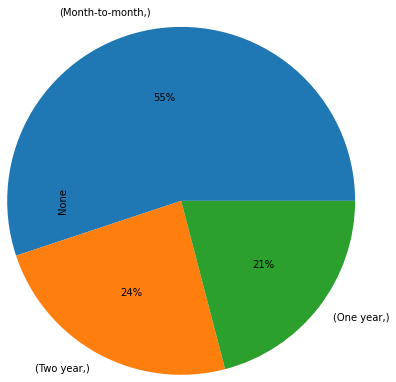

In [35]:
print(df_contract[['Type']].value_counts())
df_contract[['Type']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

Исследование колонки PaperlessBilling

PaperlessBilling
Yes                 4168
No                  2864
dtype: int64


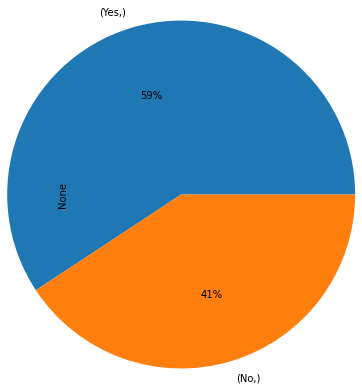

In [36]:
print(df_contract[['PaperlessBilling']].value_counts())
df_contract[['PaperlessBilling']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

безбумажным биллингом пользуется большая часть пользователей (59%) 

Исследование колонки PaymentMethod

PaymentMethod            
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
dtype: int64


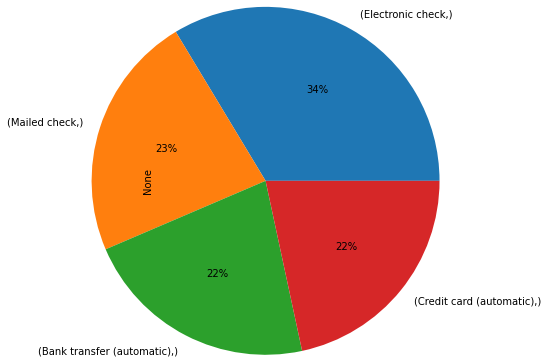

In [37]:
print(df_contract[['PaymentMethod']].value_counts())
df_contract[['PaymentMethod']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

Электронным чеком пользуется клиентов чуть больше чем остальными вариантами(Mailed check, Bank transfer, Credit card)

## Анализ датафрейма internet

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - InternetService - интернет служба 
   - OnlineSecurity - интернет безопасность
   - OnlineBackup - Облачное хранилище файлов для резервного копирования данных
   - DeviceProtection - Защита устройства 
   - TechSupport - Техническая поддержка 
   - StreamingTV - Потоковое ТВ 
   - StreamingMovies - Потоковые фильмы 

In [38]:
df_internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [39]:
df_internet['customerID'].duplicated().sum()

0

In [40]:
df_internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [41]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [42]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7255-SSFBC,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Большинство параметров нашего датафрейма у нас бинарные(судя по таблице). Напишем функцию, делающую анализ всего датафрейма сразу. Колонку customerID анализировать не будем, т.к. это просто id.

In [43]:
def analiz(dataframe):
    for i in dataframe.columns[1:]:
        print(i)
        print('Анализ колонки: "{:}"'.format(i))
        print(dataframe[i].value_counts())

        plt.figure()
        dataframe[i].value_counts().plot.pie(radius=1, autopct='%1.0f%%')
        plt.show()
        print('')
        print('')

InternetService
Анализ колонки: "InternetService"
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64


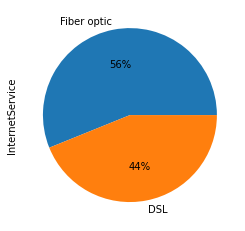



OnlineSecurity
Анализ колонки: "OnlineSecurity"
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64


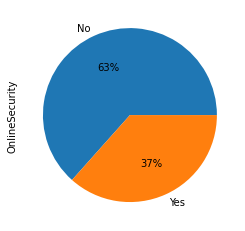



OnlineBackup
Анализ колонки: "OnlineBackup"
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64


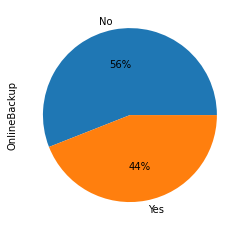



DeviceProtection
Анализ колонки: "DeviceProtection"
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64


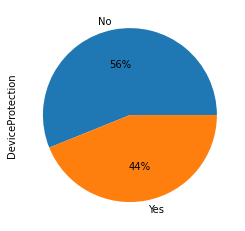



TechSupport
Анализ колонки: "TechSupport"
No     3473
Yes    2044
Name: TechSupport, dtype: int64


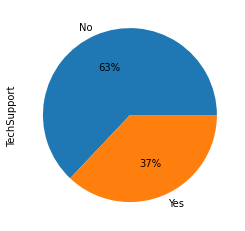



StreamingTV
Анализ колонки: "StreamingTV"
No     2810
Yes    2707
Name: StreamingTV, dtype: int64


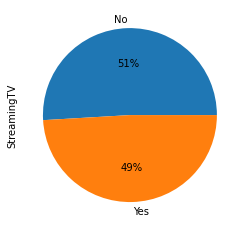



StreamingMovies
Анализ колонки: "StreamingMovies"
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64


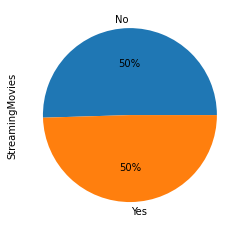

In [44]:
analiz(df_internet)

В целом познакомился с характеристиками.

## Анализ датафрейма personal

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - SeniorCitizen - пенсионер
   - Partner - женат/не женат
   - Dependents - иждивенцы

In [45]:
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [46]:
df_personal['customerID'].duplicated().sum()

0

In [47]:
df_personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

пропусков нет

In [48]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


по типам данных, все ОК

gender
Анализ колонки: "gender"
Male      3555
Female    3488
Name: gender, dtype: int64


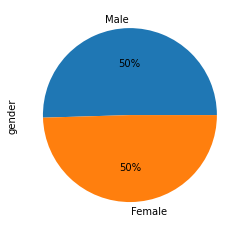



SeniorCitizen
Анализ колонки: "SeniorCitizen"
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


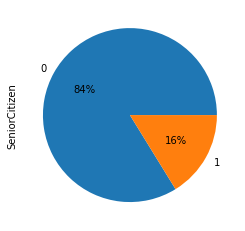



Partner
Анализ колонки: "Partner"
No     3641
Yes    3402
Name: Partner, dtype: int64


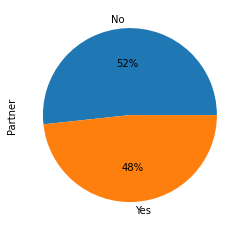



Dependents
Анализ колонки: "Dependents"
No     4933
Yes    2110
Name: Dependents, dtype: int64


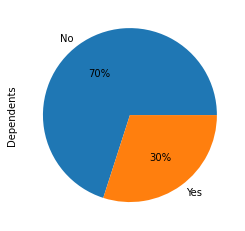

In [49]:
analiz(df_personal)

пенсионеров не так много + иждевенцев треть от всей выборки

## Анализ датафрейма phone

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - MultipleLines - несколько линий

In [50]:
df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [51]:
df_phone['customerID'].duplicated().sum()

0

In [52]:
df_phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [53]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [54]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,6873-UDNLD,No
freq,1,3390


MultipleLines
Анализ колонки: "MultipleLines"
No     3390
Yes    2971
Name: MultipleLines, dtype: int64


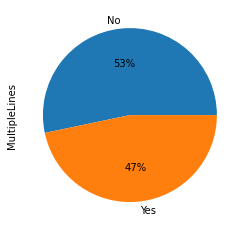

In [55]:
analiz(df_phone)

Объединим наши данные в одну таблицу

In [56]:
df_contract = df_contract.merge(df_internet, on = ['customerID'], how = 'outer')
df_contract = df_contract.merge(df_personal, on = ['customerID'], how = 'outer')
df = df_contract.merge(df_phone, on = ['customerID'], how = 'outer')

In [57]:
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,31.0,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1.0,1036.0,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0.0,61.0,...,Yes,No,No,No,No,Male,0,No,No,No


In [58]:
df.isnull().sum()

customerID             0
BeginDate             11
EndDate               11
Type                  11
PaperlessBilling      11
PaymentMethod         11
MonthlyCharges        11
TotalCharges          11
target_value          11
time_delta            11
TotalCharges_id       11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

In [59]:
df['InternetService'] = df['InternetService'].fillna('N')
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('N')
df['OnlineBackup'] = df['OnlineBackup'].fillna('N')
df['DeviceProtection'] = df['DeviceProtection'].fillna('N')
df['TechSupport'] = df['TechSupport'].fillna('N')
df['StreamingTV'] = df['StreamingTV'].fillna('N')
df['StreamingTV'] = df['StreamingTV'].fillna('N')
df['StreamingMovies'] = df['StreamingMovies'].fillna('N')
df['MultipleLines'] = df['MultipleLines'].fillna('N')

In [60]:
df.isnull().sum()

customerID           0
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
target_value        11
time_delta          11
TotalCharges_id     11
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
dtype: int64

In [61]:
df = df.dropna()

In [62]:
df.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target_value        0
time_delta          0
TotalCharges_id     0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

Посмотрим на корреляцию признаков

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target_value', 'time_delta', 'TotalCharges_id', 'SeniorCitizen']


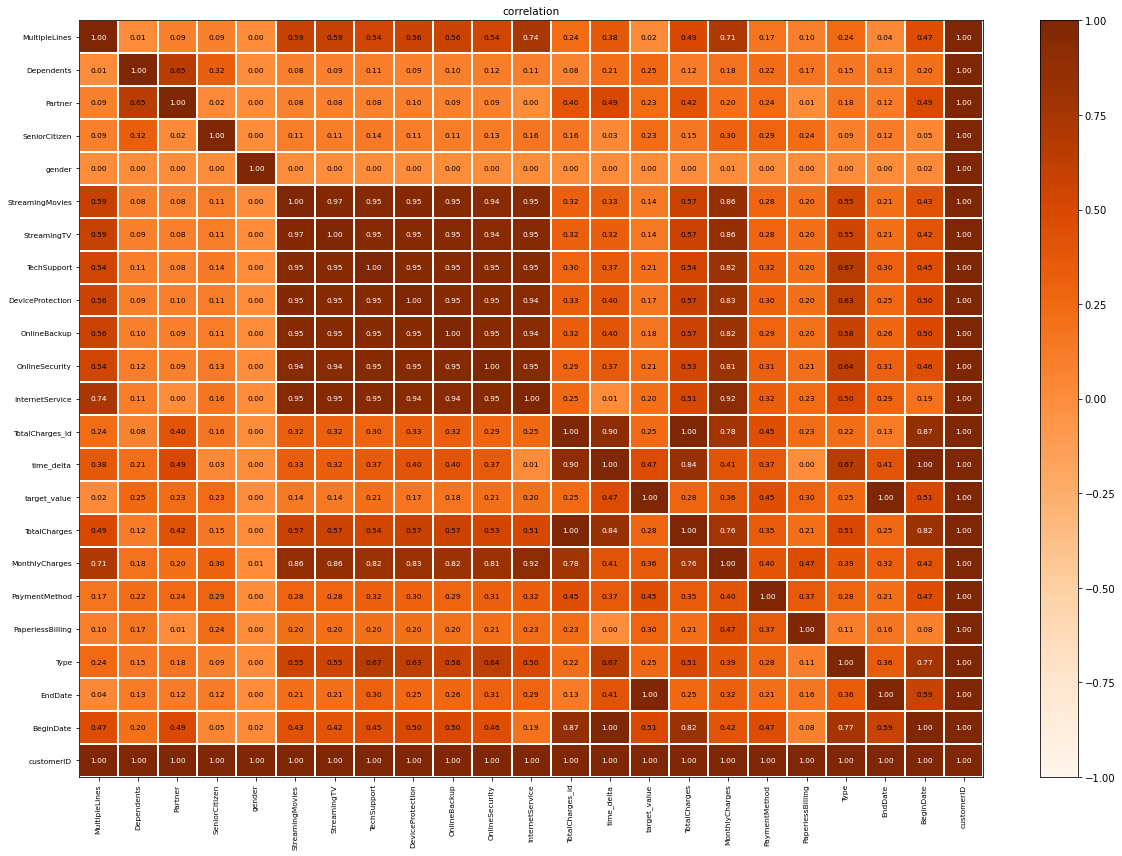

In [63]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values,
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       color_map = 'Oranges',
                       fontsize_factor = 0.75,
                       figsize = (17,12))

Очень много всего тут коррелирует. Видимо следовало бы удалить все что коррелирует выше 0.5. В общем то я в конце своей работы так и поступил, оставив только 4 ключевые фичи.

Выводы: Данные подготовили, пропуски обработали, новые фичи сгенерировали

## Обучение моделей

### Подготовка данных для обучения моделей

Удалим лишние фичи. Если  тема наших исследований НЕ временные ряды, то такие факторы не используем. Они "нагонят" метрики, но бизнес-эффективность модели  - упадет.

In [64]:
df=df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [65]:
df.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta,TotalCharges_id,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,31.0,1.0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,N
1,One year,No,Mailed check,56.95,1889.50,1.0,1036.0,1.0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,0.0,61.0,1.0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No


Преобразуем наши категориальные данные

In [66]:
df = pd.get_dummies(df, drop_first=True)
df.head(3)

,MonthlyCharges,TotalCharges,target_value,time_delta,TotalCharges_id,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
0,29.85,29.85,1.0,31.0,1.0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,0
1,56.95,1889.50,1.0,1036.0,1.0,0,1,0,0,0,...,0,1,0,1,0,1,0,0,1,0
2,53.85,108.15,0.0,61.0,1.0,0,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0


Посмотрим на матрицу корреляции полученных фичей

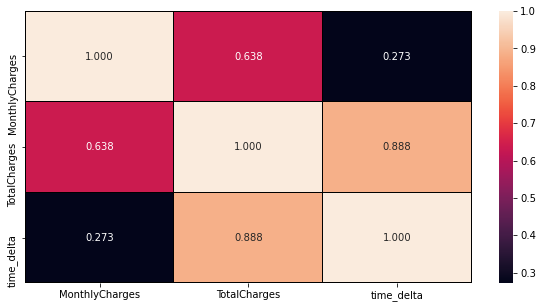

In [67]:
plt.figure(figsize=(10, 5))
sns.heatmap(df[['MonthlyCharges','TotalCharges', 'time_delta']].corr(method='spearman'), annot=True, fmt='.3f', linecolor='black', linewidths=0.1);

Обратили внимание что некоторые фичи сильно коррелируют друг с другом, при этом корреляция с целевым признаком не очень высокая. Удалим TotalCharges, т.к. мы знаем что time_delta это наша ключевой признак, а TotalCharges мы категоризировали в TotalCharges_id

In [68]:
df = df.drop(['TotalCharges'], axis=1)    

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   target_value                           7032 non-null   float64
 2   time_delta                             7032 non-null   float64
 3   TotalCharges_id                        7032 non-null   float64
 4   SeniorCitizen                          7032 non-null   int64  
 5   Type_One year                          7032 non-null   uint8  
 6   Type_Two year                          7032 non-null   uint8  
 7   PaperlessBilling_Yes                   7032 non-null   uint8  
 8   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 9   PaymentMethod_Electronic check         7032 non-null   uint8  
 10  PaymentMethod_Mailed check             7032 non-null   uint8  
 11  Inte

Скопируем наши обработанные данные чтобы потом на них обучить наши модели-лидеры

In [70]:
df_copy = df.copy()

 ### Разбивка данных

In [71]:
target = df['target_value']
features = df.drop('target_value', axis=1)

In [72]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

In [73]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.25, random_state=12345)

In [74]:
target_train.value_counts()

1.0    3110
0.0    1108
Name: target_value, dtype: int64

дисбаланс 1 к 3

Сделаем наши выборки более равновесными, увеличив "отстающую"

In [75]:
def upsample(features, target, repeat):
    features_zeros = features[target == 1]
    features_ones = features[target == 0]
    target_zeros = target[target == 1]
    target_ones = target[target == 0]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [76]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [77]:
target_upsampled.value_counts()

0.0    3324
1.0    3110
Name: target_value, dtype: int64

теперь баланс классов соблюдён

 Это списки для анализа точности и скорости работы моделей. Пока не успел реализовать..

In [78]:
time_value = []
RMSE_value = []
model = []

#### CatBoostClassifier

Закомментировал поиск по GridSearchCV т.к. работает очень долго

In [79]:
#start_time = time.time()
#cat = GridSearchCV(estimator=CatBoostClassifier(iterations  = 700),
#                   param_grid={"learning_rate": (0.05, 0.1, 0.2, 0.3, 0.4),
#                               "max_depth": [3, 5, 7, 9, 12, 15]},
#            cv=5, verbose=0, n_jobs=-1)
#
#grid_result = cat.fit(features_upsampled, target_upsampled)
#print(f'Лучшие параметры модели {grid_result.best_params_}')


##time_value.append(time.time() - start_time)
##RMSE_value.append(accuracy)
##model.append('CatBoostRegressor')

In [ ]:
start_time = time.time()

cat = GridSearchCV(estimator=CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4),
                   param_grid={},
            cv=5, verbose=0, n_jobs=-1)

grid_result = cat.fit(features_upsampled, target_upsampled)

pred_valid = grid_result.predict(features_valid)
accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)
time_value.append(time.time() - start_time)
RMSE_value.append(accuracy)
model.append('CatBoostRegressor')

In [81]:
pred_test = grid_result.predict(features_test)
accuracy = accuracy_score(target_test, pred_test)
print(accuracy)


0.8614072494669509


посмотрим что у нас с метрикой Roc-Auc

Text(0.5, 1.0, 'ROC-кривая')

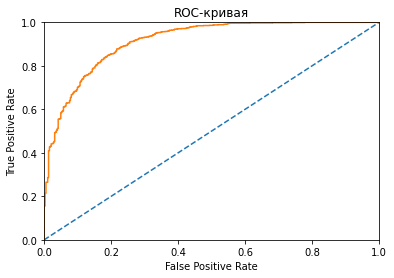

In [82]:
probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


In [83]:
probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

0.9137934991024804


#### XGBClassifier

In [84]:
#start_time = time.time()

#gsc = GridSearchCV(
#            estimator=xgb.XGBClassifier(random_state=12345),
#            param_grid={"learning_rate": (0.05, 0.1, 0.2, 0.3, 0.4),
#                        "max_depth": [3, 5, 7, 9, 12, 15],
#                        "min_child_weight": [0.1, 0.3, 0.5],
#                        "colsample_bytree":[0.2, 0.5, 0.7, 0.9, 1.0],
#                       },
#            cv=5, verbose=0, n_jobs=-1)
#
#grid_result = gsc.fit(features_upsampled, target_upsampled)
#
#print(f'Лучшие параметры модели {grid_result.best_params_}')
#pred_valid = grid_result.predict(features_valid)



In [85]:
gsc = GridSearchCV(
            estimator=xgb.XGBClassifier(random_state=12345,
                                        learning_rate = 0.025,
                                        max_depth = 4,
                                        colsample_bytree= 1.0 ),
            param_grid={},
            cv=5, verbose=0, n_jobs=-1)

grid_result = gsc.fit(features_upsampled, target_upsampled)

pred_valid = grid_result.predict(features_valid)
accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)


[12:57:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.767590618336887


Text(0.5, 1.0, 'ROC-кривая')

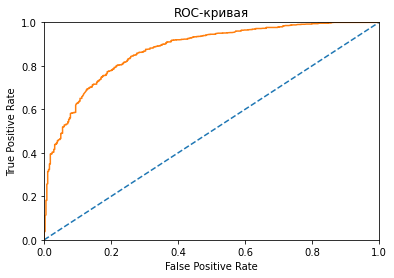

In [86]:
probabilities_test = gsc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


In [87]:
probabilities_test = gsc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

0.8738526028067886


#### RandomForestClassifier

In [88]:
#%%time

#clf_rf_cv=RandomForestClassifier(random_state=12345)
#parametrs={
#    'n_estimators':range(30,100,5),
#    'max_depth':range(2,25,3),
#},
#n_jobs=-1,

#gr=GridSearchCV(clf_rf_cv,parametrs, cv=5)
#gr.fit(features_upsampled, target_upsampled)

#print(f"Лучшее параметры модели: {(gr.best_params_)}")

#pred_valid = gr.predict(features_valid)
#RMSE = mean_squared_error(target_valid, pred_valid)**0.5
#RMSE

In [89]:
model_rand_for_reg = RandomForestClassifier(random_state=12345, n_estimators=900, max_depth=5)
start_time = time.time()

model_rand_for_reg.fit(features_upsampled, target_upsampled)

time_value.append(time.time() - start_time)
model.append('RandomForestRegressor')
accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)

0.767590618336887


0.8502111210835509


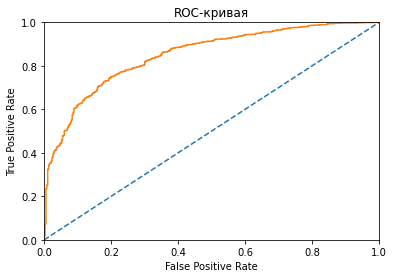

In [90]:
probabilities_test = model_rand_for_reg.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = model_rand_for_reg.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

#### LGBMClassifier

In [91]:
#start_time = time.time()
#model_lgb = GridSearchCV(estimator=lgb.LGBMClassifier(objective="binary"),
#                         
#                   param_grid={"learning_rate" : (0.05, 0.1, 0.2, 0.3, 0.4),
#                               'n_estimators' : range(30,900,5),
#                               'max_depth' : range(2,25,3)},
#                         
#                         cv=5, verbose=0, n_jobs=-1)

#grid_result = model_lgb.fit(features_upsampled, target_upsampled)
#print(f'Лучшие параметры модели {grid_result.best_params_}')

#pred_valid = model_lgb.predict(features_valid)

#accuracy = accuracy_score(target_valid, pred_valid)
#print(accuracy)

In [92]:
model_lgb = lgb.LGBMClassifier(objective='binary', n_estimators = 900, learning_rate = 0.05, max_depth = 5)
model_lgb.fit(features_upsampled, target_upsampled)
pred_valid = model_lgb.predict(features_valid)

accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)

0.8628287135749823


0.9084619268113576


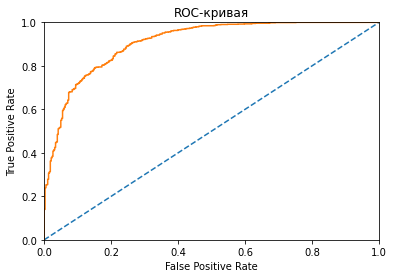

In [93]:
probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

### Анализ важности фичей

model_lgb - модель

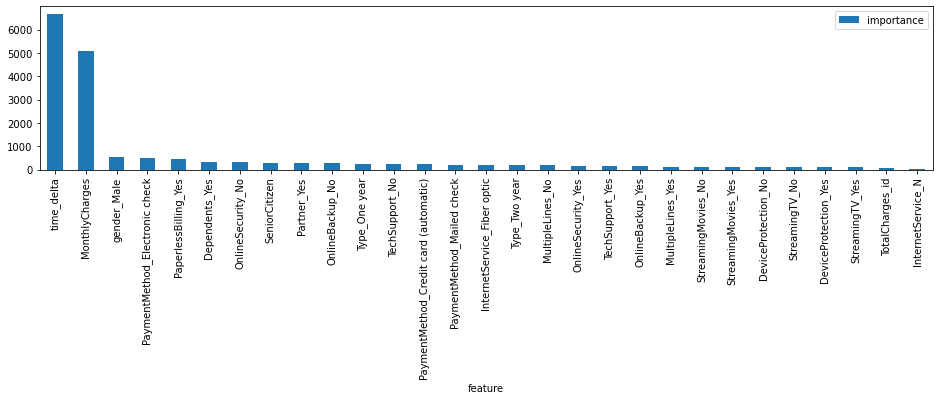

In [94]:
importances = pd.DataFrame({'feature':features_valid.columns,'importance':np.round(model_lgb.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(16, 3));

 CatBoostClassifier - модель

In [ ]:
cat = CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4, random_state=12345)
cat.fit(features_upsampled, target_upsampled)
pred_valid = grid_result.predict(features_valid)

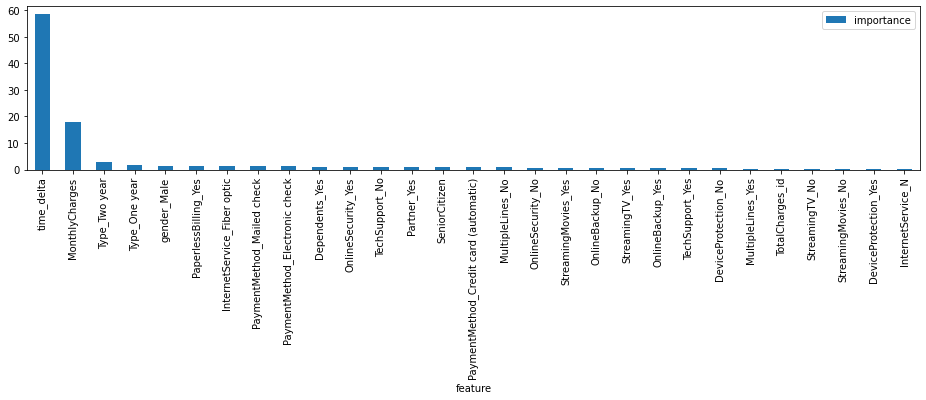

In [96]:
importances = pd.DataFrame({'feature':features_valid.columns,'importance':np.round(cat.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(16, 3));

Выводы: Наиболее полезным признаком оказался сгенерированный нами time_delta. Модель LGBMClassifier сочла не менее полезным признак MonthlyCharges.

## Финальное обучение моделей-лидеров на более полном датасете

модели с наиболее хорошими результати у нас оказались CatBoostClassifier и LGBMClassifier

Воспользуемся нашей копией данных и повторим операцию разбиения на выборки и устранение дисбаланса классов

In [97]:
df_copy.columns

Index(['MonthlyCharges', 'target_value', 'time_delta', 'TotalCharges_id',
       'SeniorCitizen', 'Type_One year', 'Type_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_N', 'OnlineSecurity_No',
       'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_Yes', 'gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'MultipleLines_No',
       'MultipleLines_Yes'],
      dtype='object')

In [98]:
df_copy

,MonthlyCharges,target_value,time_delta,TotalCharges_id,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
0,29.85,1.0,31.0,1.0,0,0,0,1,0,1,...,0,1,0,1,0,0,1,0,0,0
1,56.95,1.0,1036.0,1.0,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
2,53.85,0.0,61.0,1.0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,0,1,0
3,42.30,1.0,1371.0,1.0,0,1,0,0,0,0,...,1,1,0,1,0,1,0,0,0,0
4,70.70,0.0,61.0,1.0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84.80,1.0,730.0,1.0,0,1,0,1,0,0,...,1,0,1,0,1,1,1,1,0,1
7028,103.20,1.0,2191.0,0.0,0,1,0,1,1,0,...,0,0,1,0,1,0,1,1,0,1
7029,29.60,1.0,337.0,1.0,0,0,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
7030,74.40,0.0,123.0,1.0,1,0,0,1,0,0,...,0,1,0,1,0,1,1,0,0,1


In [99]:
df_copy = df_copy[['time_delta',
                   'MonthlyCharges',
                   'Type_Two year',
                   'target_value']]

In [100]:
target = df_copy['target_value']
features = df_copy.drop('target_value', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
     features, target, test_size=0.2, random_state=12345)

print(target_train.value_counts())

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(target_upsampled.value_counts())

1.0    4139
0.0    1486
Name: target_value, dtype: int64
0.0    4458
1.0    4139
Name: target_value, dtype: int64


На полученном более полном датасете обучим обе наши модели

In [ ]:
cat = GridSearchCV(estimator=CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4),
                   param_grid={},
            cv=5, verbose=0, n_jobs=-1)
grid_result = cat.fit(features_upsampled, target_upsampled)
pred_test = grid_result.predict(features_test)

0.8628287135749823
0.9267093668407311


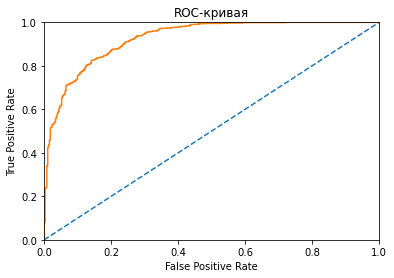

In [102]:
accuracy = accuracy_score(target_test, pred_test)
print(accuracy)

probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

In [ ]:
cat = CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4, random_state=12345)
cat.fit(features_upsampled, target_upsampled)
pred_valid = grid_result.predict(features_test)

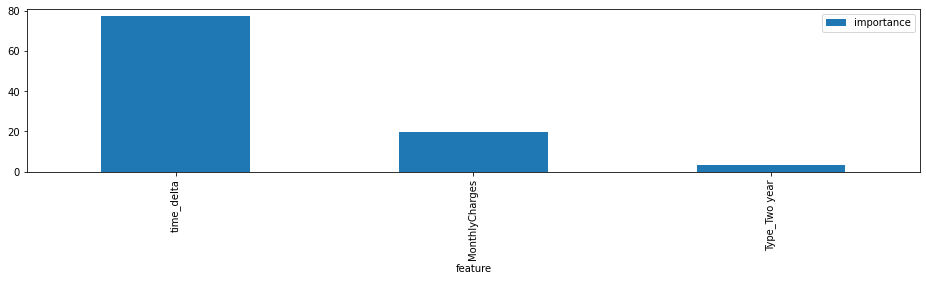

In [104]:
importances = pd.DataFrame({'feature':features_test.columns,'importance':np.round(cat.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(16, 3));

In [105]:
model_lgb = lgb.LGBMClassifier(objective='binary', n_estimators = 900, learning_rate = 0.05, max_depth = 5)
model_lgb.fit(features_upsampled, target_upsampled)
pred_test = model_lgb.predict(features_test)

0.8585643212508884
0.9241022254406006


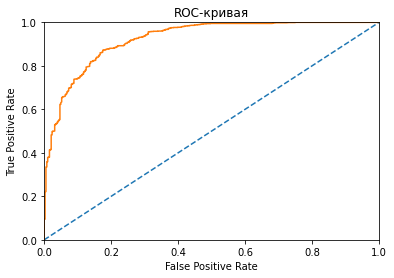

In [106]:
accuracy = accuracy_score(target_test, pred_test)
print(accuracy)

probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

Обе модели отработали примерно одинаково. 

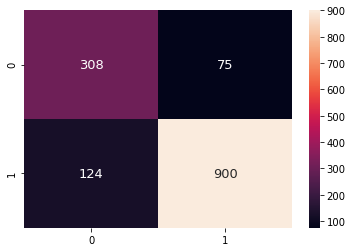

In [107]:
sns.heatmap(confusion_matrix(target_test, pred_test), annot=True, fmt='.0f', annot_kws={'fontsize':13});

у нас почти в 2 раза больше ошибок False Negative, чем False Positive

False Positive: ошибка 1-го рода, ML-модель предсказала, что в 75 случаях из нашей тестовой выборки мы не увидим что клиент собирается уйти. 

Ущерб от этого состоит в том что мы не работаем с ними (не предлогаем спец. предложений/скидок и прочих благ) чтобы клиент остался. и клиент уходит.... 

False Negative: ошибка 2-го рода – ML-модель предсказала, что в 124 случаях мы ложно отнесли клиентов, которые не хотят никуда уходить к клиентам собравшимся покинуть нашу компанию.

Ущерб от этого состоит в том что мы ошибочно полагаем что клиент хочет уйти и предлогаем ему всевозможные скидки и спец. предложения, когда как он и так себя прекрасно чувствовал и уходить не собирался. 

Как мне кажется : наиболее критично в данном случае это удержать клиентов которые хотят уйти и соответственно было бы наиболее перспективно повышать метрику.

In [108]:
precision_score(target_test, pred_test)

0.9230769230769231

In [109]:
recall_score(target_test, pred_test)

0.87890625

precision - это доля людей которые хотят уйти, которые были классифицированы как люди которые хотят уйти (другими словами, какое у нас количество «ложных срабатываний»)

recall - доля людей которые хотят от нас уйти, которых мы "вычислили". (другими словами, какое у нас количество «ложных пропусков»)

Таким образом, необходимо подсчитать что для нас выгоднее: 

    - во что бы то ни стало оставлять клиентов (остановить отток даже платя тем кто не собирался уходить)
    - не переплачивать людям которые и так наши клиенты, но как следствие повысится кол-во желающих уйти не получивших предложения о скидке.
    

## Выводы

Максимальная метрика ROC-AUC = 0.92.
    
Наиболее ценными признаками оказались: время клиента и ежемесячные отчисления. По идее, пользуясь именно этими параметрами должен быть расчитан размер индивидуального предложения для удержания клиента(например, опираясь на отношение потраченного время к потраченным деньгам).
    
Были выявлены следующие трудности:
  - отсутствие таргетного признака (0/1) в исходном датасете
  - пропуски в данных
  - дисбаланс классов
  - исходные данные были переданы не в тех форматах (например числовой в строковом формате)
  - числовые и категориальные признаки сильно коррелировали друг с другом (не имеем ввиду target)

Преодоление трудностей:
  - сгенерировал таргетный признак пользуясь данными даты входа и выхода клиента из компании. 
  - В случае когда пропусков было мало (в данном случае 11) удалил. В остальных случаях достоверно осуществить замену не представлялось возможным, а при удалении терялся очень большой объем данных, так что была осуществлена замена пропусков на букву "N".
  - с дисбалансом классов боролся увеличив "отстающий" класс
  - исправил форматы на необходимые
  - удалил коррелирующие друг с другом признаки
  
Ключевые шаги:
   - загрузка данных
   - знакомство и предварительный анализ данных
   - коррекция и приведение данных к нужной форме и содержанию
   - анализ данных
   - подготовка данных к использованию в ML
   - обучение нескольких моделей, выбор наиболее эффективных
   - исследование ключевых фичей и последующая подготовка(коррекция) данных для финального обучения
   - финальное обучение моделей-лидеров на подготовленных данных
   - исследование полученных результатов
   - выводы
   
Итоговая модель(наилучшая): CatBoostClassifier с качеством ROC-AUC = 0.926